## Comparing tool variability and numerical variability in fMRI analyses

In this project, we aim to study how the numerical variability is in comparison with the tool variability
and how the fMRI preprocessing pipelines are numerically stable.
For this purpose, we replicate fMRI analyses used in [Bowring's paper](https://onlinelibrary.wiley.com/doi/full/10.1002/hbm.24603) with different tools using the MCA perturbation method ([fuzzy libmath](https://github.com/big-data-lab-team/MCA-libmath)), and then compare the variability between tool changes and the MCA-based model.



## Data processing

- In this work, we replicate [the fMRI analyses](https://github.com/NISOx-BDI/Software_Comparison) across three of the most popular software packages in neuroimaging including FSL, AFNI, and SPM. There are three functional fMRI studies with the publicly available data repository, including:
  - Balloon analog risk task on 16 subjects (ds000001)
  - False belief task on 48 subjects (ds000109)
  - Reward processing across different age groups on 30 subjects (ds000120)


- We build docker images containing requisites for running the fMRI analyses such as processing tools (FSL, AFNI, SPM) and their dependencies, and the libmath fuzzy environment for applying MCA perturbations.


- We produce different result samples by running the fMRI preprocessing steps in each study in two conditions, with and without instrumentations, using the three software packages.


- We then compare activation regions visually and maps of the computed number of significant digits statistically in each condition.



### Code section

In [1]:
import os
from subprocess import check_call
import zipfile
from nilearn import plotting
import shutil
import pandas as pd

import numpy as np
import nibabel as nib
import os.path as op

In [2]:
# From https://raw.githubusercontent.com/gkpapers/2020AggregateMCA/master/code/utils.py
def sigdig(array, base=2, axis=-1):
    '''
    Compute significant digits of array elements along axis
    '''
    try:
        # If we have a float, this is our value of epsilon
        eps = np.finfo(array.dtype).eps
    except ValueError:
        # If it's an int, we want to convert it to a float of the same number of
        # bits to get our estimate of epsilon
        a2_dtype = "np.float{0}".format(array.dtype.itemsize*8)
        a2 = array.astype(eval(a2_dtype))
        warnings.warn("Converting array from {} to {}".format(array.dtype,
                                                              a2.dtype),
                      Warning)
        # Re-call the function with the float version
        return sigdig(a2, base=base, axis=axis)

    # Initialize empty matrix the same size of the array
    shp = list(array.shape)
    shp.pop(axis)
    sigs = np.empty(shp)
    sigs[:] = np.NaN

    # Compute the standard deviation and handle special case 1:
    #   - if no variance, maximum significance
    sd = np.std(array, axis=axis)
    c1locs = np.where(sd == 0)
    sigs[c1locs] = -np.log(eps)/np.log(base)

    # Compute the mean and handle special case 2:
    #   - if mean of 0, no significance.
    #   - N.B. this is the incorrect formula for zero-centered data
    mn = np.mean(array, axis=axis)
    c2locs = np.where(mn == 0)
    for c2l in zip(*c2locs):
        if np.isnan(sigs[c2l]):
            sigs[c2l] = 0

    # Otherwise, compute the number of significant digits using Parker, 1997
    c3locs = np.where(np.isnan(sigs))
    for c3l in zip(*c3locs):
        sigs[c3l] = -np.log(np.abs(sd[c3l] / mn[c3l]) + eps)/np.log(base)

    # Reset any negative values to zero
    c4l = np.where(sigs <= 0)
    sigs[c4l] = 0

    # Round up to nearest full bit, and return
    sigs = np.ceil(sigs).astype(int)
    return sigs

In [3]:
# FSL STATS NIDM Results
num_subjects = 16
def fsl_stat(study):
    # *** FSL group activations and deactivations
    fsl_pack = open('./results/' + study + '/group.gfeat.nidm.zip', 'rb')
    z = zipfile.ZipFile(fsl_pack)
    z.extract('ExcursionSet_T001.nii.gz', './results/' + study + '/')
    z.extract('ExcursionSet_T002.nii.gz', './results/' + study + '/')
    z.extract('Mask.nii.gz', './results/' + study + '/')
    z.extract('TStatistic_T001.nii.gz', './results/' + study + '/')

    # Unthresholded statistics
    fsl_stat_file = './results/' + study + '/fsl_stat.nii.gz'
    shutil.move('./results/' + study + '/TStatistic_T001.nii.gz', fsl_stat_file)
    return fsl_stat_file

# SPM STATS NIDM Results
def spm_stat(study):
    # *** SPM group activations
    spm_pack = open('./results/' + study + '/spm_0002.nidm.zip', 'rb')
    z = zipfile.ZipFile(spm_pack)
    z.extract('ExcursionSet.nii.gz', './results/' + study + '/')
    z.extract('Mask.nii.gz', './results/' + study + '/')
    z.extract('TStatistic.nii.gz', './results/' + study + '/')
    
    # Unthresholded statistics
    spm_stat_file = './results/' + study + '/spm_stat.nii.gz'
    shutil.move('./results/' + study + '/TStatistic.nii.gz', spm_stat_file)
    return spm_stat_file


## Group level analysis 
#### Balloon analog risk task on 16 subjects (ds000001)
We obtained identical results between runs; there is no randomness.

In [4]:
study = 'original/FSL'
fsl_stat_orig = fsl_stat(study)
study = 'replicated-without-instrumentation/run1/FSL'
fsl_stat_replicate1 = fsl_stat(study)
study = 'replicated-without-instrumentation/run2/FSL'
fsl_stat_replicate2 = fsl_stat(study)


Replication of the original experiment


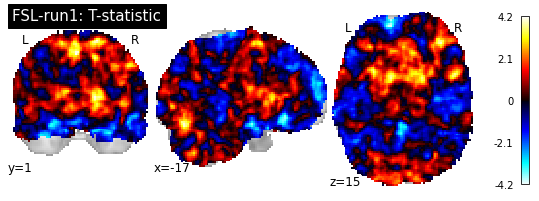

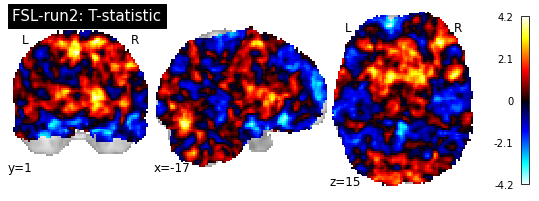

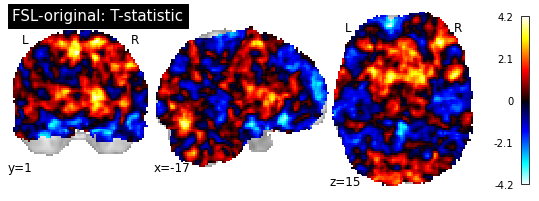

In [5]:
def plot_stat_images(fsl_stat_file_run1, fsl_stat_file_run2, max_activation, array, Title, fsl_stat_file_orig=None):
    plotting.plot_stat_map(fsl_stat_file_run1, vmax=max_activation, title="FSL-run1: " + Title, display_mode='ortho', cut_coords=array, draw_cross=False)
    plotting.plot_stat_map(fsl_stat_file_run2, vmax=max_activation, title="FSL-run2: " + Title, display_mode='ortho', cut_coords=array, draw_cross=False)
    if fsl_stat_file_orig is not None:
        plotting.plot_stat_map(fsl_stat_file_orig, vmax=max_activation, title="FSL-original: " + Title, display_mode='ortho', cut_coords=array, draw_cross=False)
    plotting.show()

print("Replication of the original experiment")
max_activation=4.2
plot_stat_images(fsl_stat_replicate1, fsl_stat_replicate2, max_activation, [-17, 1, 15], 'T-statistic', fsl_stat_orig)


Replication of the original experiment



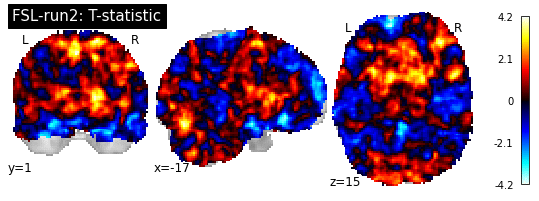

In [6]:
print("Replication of the original experiment")
# convert -loop 0 1.png 2.png group-level-fsl.gif
def show_gif(fname):
    import base64
    from IPython import display
    with open(fname, 'rb') as fd:
        b64 = base64.b64encode(fd.read()).decode('ascii')
    return display.HTML(f'<img src="data:image/gif;base64,{b64}" />')

show_gif('./figures/group-level-fsl.gif')

### SPM Results

In [4]:
study = 'original/SPM'
spm_stat_orig = spm_stat(study)
study = 'replicated-without-instrumentation/run2/SPM'
spm_stat_replicate1 = spm_stat(study)
study = 'replicated-without-instrumentation/run3/SPM'
spm_stat_replicate2 = spm_stat(study)

Replication of the original experiment


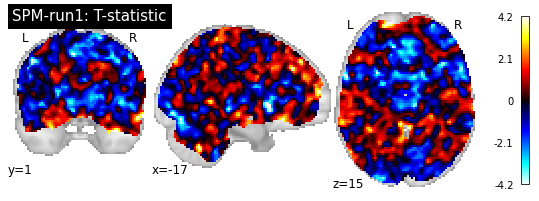

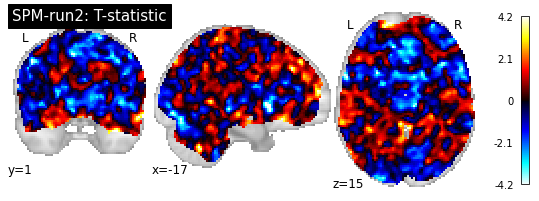

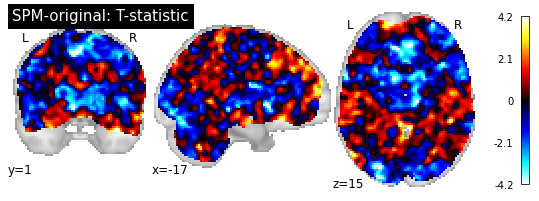

In [5]:
def plot_stat_images2(fsl_stat_file_run1, fsl_stat_file_run2, max_activation, array, Title, fsl_stat_file_orig=None):
    plotting.plot_stat_map(fsl_stat_file_run1, vmax=max_activation, title="SPM-run1: " + Title, display_mode='ortho', cut_coords=array, draw_cross=False)
    plotting.plot_stat_map(fsl_stat_file_run2, vmax=max_activation, title="SPM-run2: " + Title, display_mode='ortho', cut_coords=array, draw_cross=False)
    if fsl_stat_file_orig is not None:
        plotting.plot_stat_map(fsl_stat_file_orig, vmax=max_activation, title="SPM-original: " + Title, display_mode='ortho', cut_coords=array, draw_cross=False)
    plotting.show()

print("Replication of the original experiment")
max_activation=4.2
plot_stat_images2(spm_stat_replicate1, spm_stat_replicate2, max_activation, [-17, 1, 15], 'T-statistic', spm_stat_orig)


Replication of the original experiment



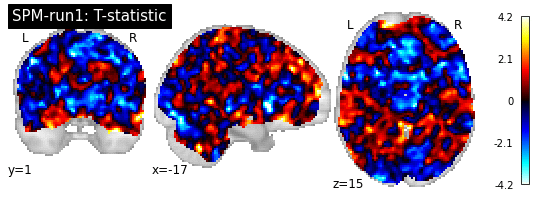

In [7]:
print("Replication of the original experiment")
show_gif('./figures/group-level-spm.gif')

## Instrumented Results

Intrumented results at virtual precisions t(double)=53 bits and t(float)=24 bits


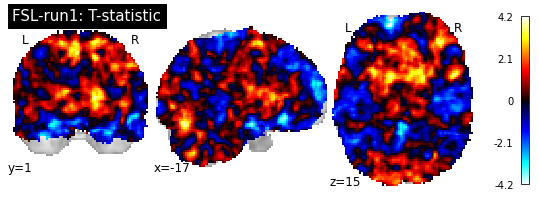

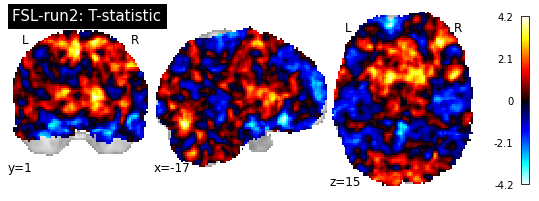

In [13]:
study = 'instrumented/p53-run1/FSL/'
fsl_stat_run1 = fsl_stat(study)
study = 'instrumented/p53-run2/FSL/'
fsl_stat_run2 = fsl_stat(study)

print("Intrumented results at virtual precisions t(double)=53 bits and t(float)=24 bits")
max_activation=4.2
plot_stat_images(fsl_stat_run1, fsl_stat_run2, max_activation, [-17, 1, 15], 'T-statistic')


Intrumented results at virtual precisions t(double)=53 bits and t(float)=24 bits



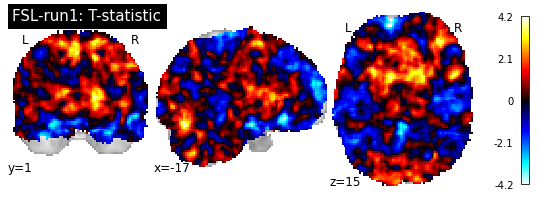

In [12]:
print("Intrumented results at virtual precisions t(double)=53 bits and t(float)=24 bits")
show_gif('./figures/group-level-fsl-p53.gif')

## First level analysis - indivisual preprocessing
### Significant digits

In [5]:
images = []
for i in range(1,4):
    images.append("./results/instrumented/p53-run{}/PREPROCESSING/ANATOMICAL/sub-04_T1w_brain.nii.gz".format(i))
array = np.array([(nib.load(image_file).get_fdata()) for image_file in images])
sigdigs = sigdig(array, base=10, axis=0)


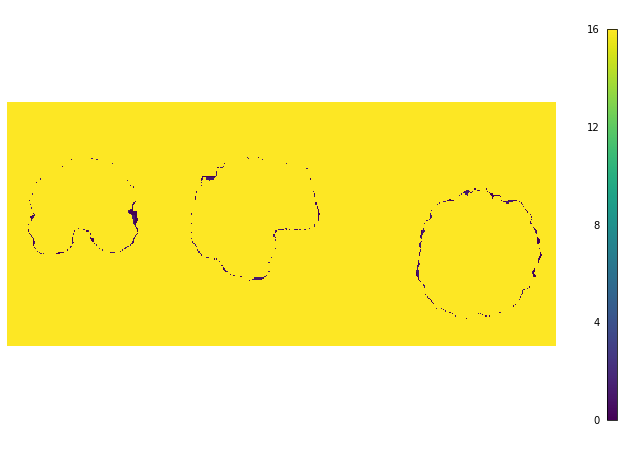

In [12]:
from nilearn import plotting as nilp
import matplotlib as mpl
from matplotlib import pyplot as plt


def plot_array(array, cmap=mpl.cm.viridis):
    fig, axes = plt.subplots(nrows=1,ncols=1,figsize=(11, 8))
    ni_img = nib.Nifti1Image(array, nib.load(images[0]).affine)

    #fig.suptitle("(b) Distributions of significant bits averaged among 20 subjects on MNI space", fontsize=14)
    nilp.plot_img(ni_img, draw_cross=False, cmap=cmap, axes=axes,
                  annotate=False, black_bg=False, colorbar=True)

# Load brain mask
#mask_name ="./masks/mask.nii.gz"
#mask = nib.load(mask_name)

# Mean sigdigits
#np.mean(sigdigs, where=mask.get_fdata().astype('bool'))

# Plot masked sigdigits
#mask_data = mask.get_fdata()
#masked_sigdigs = np.where(mask_data>0, sigdigs, mask_data)
plot_array(sigdigs)

On the next steps:

- Apply mask on indivisual results (on which mask should I map the results?)

- running the same analysis (ds001) using SPM, then AFNI
- comparing resutls across tools with MCA samples